In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Load

In [12]:
transform = torchvision.transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # crop 80–100% area, resize to 128×128
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(10, translate=(0.1, 0.1)),    # allow small rotation/translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Load training and test sets
train_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Image Classifier/seg_train', transform=transform)
test_dataset  = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Image Classifier/seg_test', transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:
K = len(train_dataset.classes)
print("number of classes:", K)

number of classes: 6


In [14]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=1,
                          shuffle=True)

for x, y in tmp_loader:
  print(x)
  print(x.shape)
  break

tensor([[[[-0.0039, -0.0275,  0.0039,  ..., -1.0000, -1.0000, -1.0000],
          [-0.0588, -0.0039,  0.0588,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.0118,  0.0196,  0.0588,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.0824,  0.0510,  0.0824,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.0431,  0.0824,  0.1373,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.1137,  0.1059,  0.1373,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.3647,  0.3333,  0.3647,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.3176,  0.3647,  

In [15]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()

    # define the conv layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )

    # Useful: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d
    # H_out = H_in + 2p - 2 --> p = 1 if H_out = H_in

    # Easy to calculate output
    # 32 > 16 > 8 > 4

    # define the linear layers
    self.fc1 = nn.Linear(128 * 16 * 16, 1024)
    self.fc2 = nn.Linear(1024, K)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x

In [16]:
model = CNN(K)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):

    model.train()

    t0 = datetime.now()
    train_loss = []

    batch = 1

    for inputs, targets in train_loader:

      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # print("inputs.shape:", inputs.shape)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      # print("about to get model output")
      outputs = model(inputs)
      # print("done getting model output")
      # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
      loss = criterion(outputs, targets)

      # Backward and optimize
      # print("about to optimize")
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      print("batch:", batch)

      batch = batch + 1

    batch = 0

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses

In [20]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=80,)

Streaming output truncated to the last 5000 lines.
batch: 275
batch: 276
batch: 277
batch: 278
batch: 279
batch: 280
batch: 281
batch: 282
batch: 283
batch: 284
batch: 285
batch: 286
batch: 287
batch: 288
batch: 289
batch: 290
batch: 291
batch: 292
batch: 293
batch: 294
batch: 295
batch: 296
batch: 297
batch: 298
batch: 299
batch: 300
batch: 301
batch: 302
batch: 303
batch: 304
batch: 305
batch: 306
batch: 307
batch: 308
batch: 309
batch: 310
batch: 311
batch: 312
batch: 313
batch: 314
batch: 315
batch: 316
batch: 317
batch: 318
batch: 319
batch: 320
batch: 321
batch: 322
batch: 323
batch: 324
batch: 325
batch: 326
batch: 327
batch: 328
batch: 329
batch: 330
batch: 331
batch: 332
batch: 333
batch: 334
batch: 335
batch: 336
batch: 337
batch: 338
batch: 339
batch: 340
batch: 341
batch: 342
batch: 343
batch: 344
batch: 345
batch: 346
batch: 347
batch: 348
batch: 349
batch: 350
batch: 351
batch: 352
batch: 353
batch: 354
batch: 355
batch: 356
batch: 357
batch: 358
batch: 359
batch: 360
bat

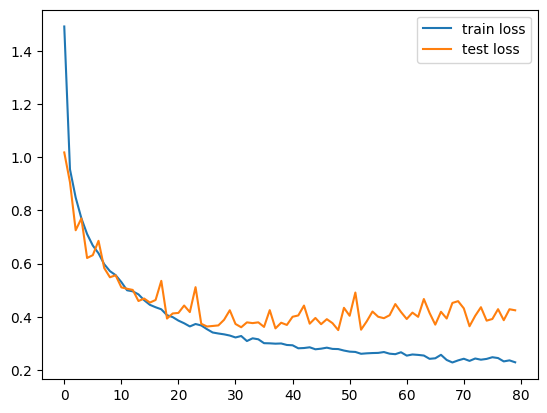

In [21]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [22]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9304, Test acc: 0.8853


In [25]:
print(type(test_dataset))

<class 'torchvision.datasets.folder.ImageFolder'>


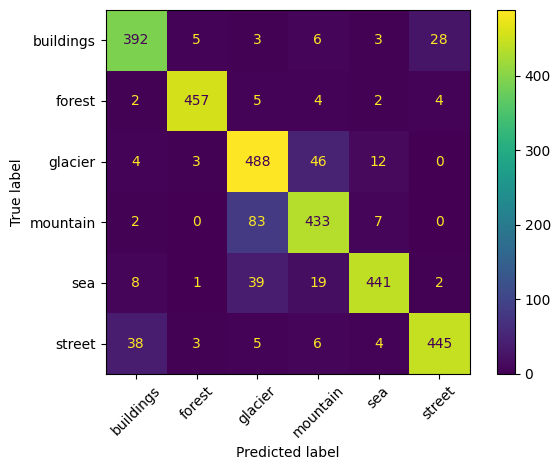

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, targets in test_loader:   # make sure test_loader has shuffle=False
        inputs = inputs.to(device)
        outputs = model(inputs)

        # preds: argmax over class dimension
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(targets.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

num_classes = len(test_dataset.classes)  # class names come from folder names
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_dataset.classes)
disp.plot(xticks_rotation=45)
plt.tight_layout()
plt.show()